#  Predicting the success of a bank deposit marketing campaign

The dataset we will use in this project is available for public and related with direct marketing campaigns of a Portuguese banking institution (check for the details here: [Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.)

The goal of this project is to predict if the client will subscribe to a term deposit (variable y).

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Set seaborn 
sns.set_style("whitegrid")
sns.set(font_scale=1.2)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Let's loaf the data set and inspect its content.

In [2]:
#Load data
bank=pd.read_csv('bank_part.csv')

In [3]:
# Look at the data
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,29,admin.,single,secondary,no,428,yes,yes,cellular,7,may,54,1,345,2,failure,no
1,30,admin.,single,secondary,no,818,yes,yes,cellular,16,apr,66,1,346,1,failure,no
2,36,self-employed,single,tertiary,no,353,no,no,cellular,11,aug,361,2,181,2,success,yes
3,35,services,divorced,secondary,no,440,yes,no,cellular,5,feb,103,1,248,1,failure,no
4,60,technician,married,secondary,no,1139,no,no,cellular,6,feb,67,2,207,2,failure,no


### Checking for missing variables

In [4]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4264 non-null   int64 
 1   job        4264 non-null   object
 2   marital    4264 non-null   object
 3   education  4264 non-null   object
 4   default    4264 non-null   object
 5   balance    4264 non-null   int64 
 6   housing    4264 non-null   object
 7   loan       4264 non-null   object
 8   contact    4264 non-null   object
 9   day        4264 non-null   int64 
 10  month      4264 non-null   object
 11  duration   4264 non-null   int64 
 12  campaign   4264 non-null   int64 
 13  pdays      4264 non-null   int64 
 14  previous   4264 non-null   int64 
 15  poutcome   4264 non-null   object
 16  y          4264 non-null   object
dtypes: int64(7), object(10)
memory usage: 566.4+ KB


The data contains 17 columns with 4264 variables in each column. As we can see, none of the columns contain null values.

The columns of the data frame contain the following variables:
* age(numeric)
* job: type of job (categorical: "admin.","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services") 
* arital: marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
* education (categorical: "secondary","primary","tertiary")
* default: has credit in default? (binary: "yes","no")
* balance: average yearly balance, in euros (numeric) 
* housing: has housing loan? (binary: "yes","no")
* loan: has personal loan? (binary: "yes","no")
    
* contact: contact communication type (categorical:"telephone","cellular") 
* day: last contact day of the month (numeric)
* month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
* duration: last contact duration, in seconds (numeric)

    
* campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
* previous: number of contacts performed before this campaign and for this client (numeric)
* poutcome: outcome of the previous marketing campaign (categorical: "failure","success")

* y: has the client subscribed a term deposit? (binary: "yes","no") 


Let's rename the target column (column 'y') so the column name is more informative.

In [5]:
# Rename the target column
bank.rename(columns={'y':'subscription'},inplace=True)

## Exploratory Data Analysis

Let's start with some exploratory data analysis. We will look at every variable and see how different variables were related to
the outcome of the deposit marketing campaign.


### How many bank clients subscribed to the deposit?

In [6]:
bank['subscription'].value_counts()

no     3227
yes    1037
Name: subscription, dtype: int64

In [7]:
bank['subscription'].value_counts(normalize=True)

no     0.756801
yes    0.243199
Name: subscription, dtype: float64

We can se that approximately 24.3% of bank clients who were contacted during the campaign subscribed to the deposit and around 75.7% did not sunbscribe.

Since the data is only mildly imbalanced, we will try to train our models without applying any techniques to address it.

### Is customer's age related to the marketing campaign outcome?

In [8]:
#Function to plot feature distribution

def distribution_plot(df,colname,title,hist=True,bins=30):
    
    f, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title,fontsize=18)
    sns.distplot(df[colname],bins=bins,ax=ax)
    plt.show()

In [9]:
# Function to plot subscription density by feature

def subsription_dist_by_feature(df,colname,title):
    
    f, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title,fontsize=18)
    
    sns.kdeplot(data=df,x=colname,hue='subscription',shade=True,ax=ax).set_xlabel(colname)
    plt.show()

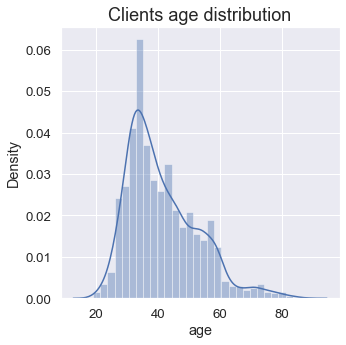

In [10]:
distribution_plot(bank,'age','Clients age distribution')

We can see that the distribution of customers' ages is right-skewed: the most represented age group is 28-34 years old,
and for customers older than 34 the representation of the age groups overall decreases for higher ages.

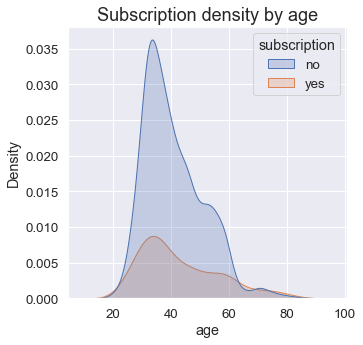

In [11]:
subsription_dist_by_feature(bank,'age','Subscription density by age')

As shown by the plot, customer's age affected campaign outcome. We can see, that for the lowest customer's age group (under 23),
the percentage of subscribed customers was even higher than that of non-subscribers, for customers over 23 the percentage of 
non-subscribers was significantly higher than that of subscribed clients and this difference increased as clients age invreased 
till 34. For clients over 34 years old, the difference between the persentages of non-subscribers and subscribers overally 
decreased. For clients over 65, the number of subscribers and non-subscribers was roughly the same (for some ages, the percentage 
                                                            of clients who subscribed was even higher than the percentage of non-subscribers)

### Is customer's job type related to the marketing campaign outcome?

In [12]:
# Plot to compare categories' infuelnce on subscription outcome

def countplot_compare(df,colname1,colname2,title,fsize):
    
    f, ax = plt.subplots(figsize=fsize)
    ax.set_title(title,fontsize=18)
    
    sns.countplot(x=colname1,hue=colname2, data=df,ax=ax)
    plt.show()   

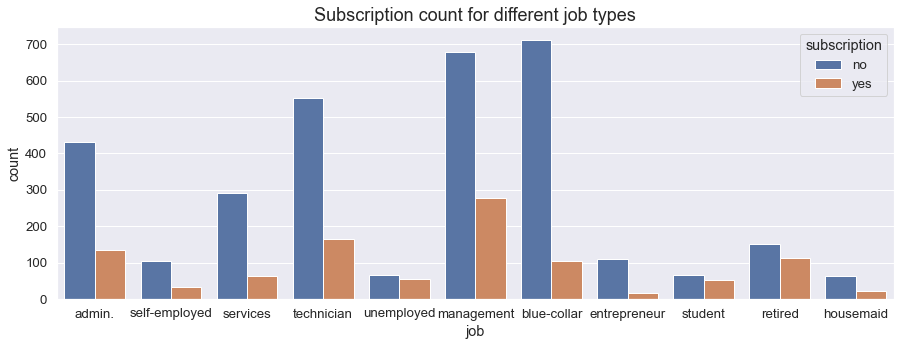

In [13]:
countplot_compare(bank,'job','subscription','Subscription count for different job types',(15,5))

We can see that among the contacted clients, the most represented job types were 'blue-collar','management job','technician'
and 'administrative'.

In [14]:
# Function to compare percentages of subscribers and non-subscribers among categorical variables
def plot_cat_perc(df,colname1,colname2,title,height,aspect):
    
    df1 = df.groupby(colname1)[colname2].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()
    
    g = sns.catplot(x=colname1,y='percent',hue=colname2,data=df1,kind='bar',height=height, aspect=aspect)
    
    g.ax.set_ylim(0,100)
    g.ax.set_title(title,fontsize=18)

    for p in g.ax.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x()
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt,fontsize=16)
      
    plt.show()

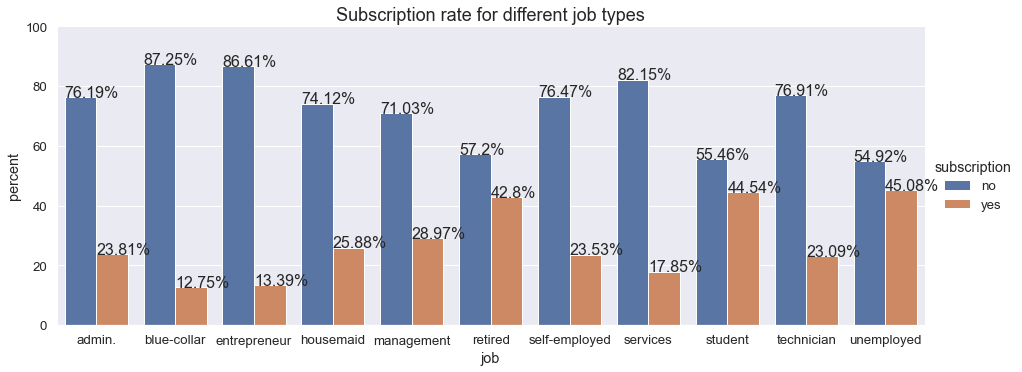

In [15]:
plot_cat_perc(bank,'job','subscription','Subscription rate for different job types',5,13/5)

Overall, the client's job type affected the outcome of the campaign. 

As it is easy to see, the highest percentage of deposit subscription was for unemployed and retired customers as well as for
students, although these categories were not the most represented ones in this campaign.

The lowest percentage of clients who subscribed to deposit was for customers who had 'blue-collar' and 'entrepreneur' job types.

### Does costomer's marital stus affect the marketing campaign outcome?

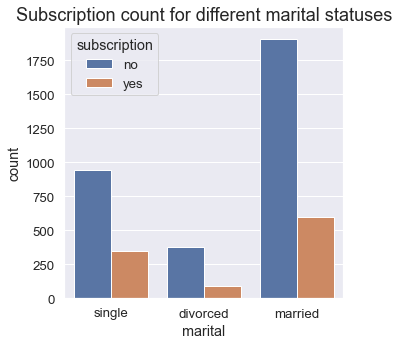

In [16]:
countplot_compare(bank,'marital','subscription','Subscription count for different marital statuses',(5,5))

Evidently, the majority of the contacted clients were married, and the group of clients who were divorced was the least represented
in this campaign.

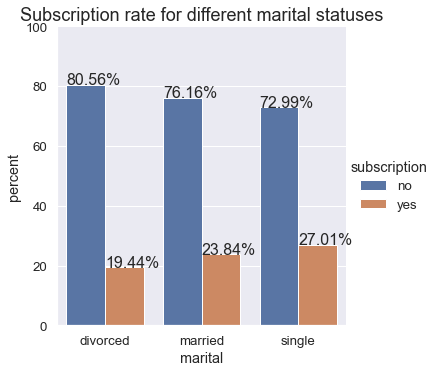

In [17]:
plot_cat_perc(bank,'marital','subscription','Subscription rate for different marital statuses',5,5/5)

As can be seen,clients marital status affected the outcome of the camaign.
The highest subscription percentage was observed for single clients, whereas the lowest subscribtion percentage
was among divorced clients.

### Does education level affect the marketing campaign?

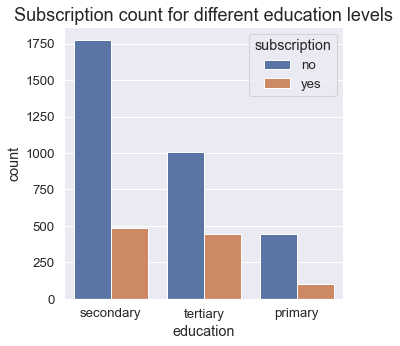

In [18]:
countplot_compare(bank,'education','subscription','Subscription count for different education levels',(5,5))

We can see that the majority of the contacted bank clients had the secondary education.

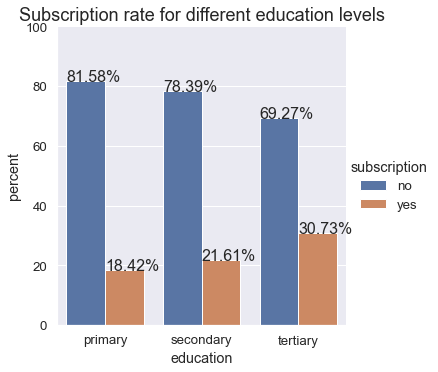

In [19]:
plot_cat_perc(bank,'education','subscription','Subscription rate for different education levels',5,5/5)

Overall, the education level had some effect on the outcome of the campaign. The highest percentage of subscribers was observed
for customers with tertiary education, and the lowest percentage of subscribers was among customers with primary education.

### Does default stus affect the marketing camapign outcome?

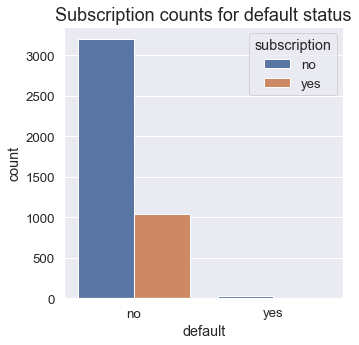

In [20]:
countplot_compare(bank,'default','subscription','Subscription counts for default status',(5,5))

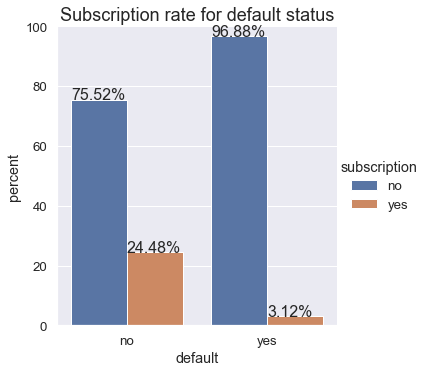

In [21]:
plot_cat_perc(bank,'default','subscription','Subscription rate for default status',5,5/5)

We can see that default status significantly affects clients subscription (the subscription rate is significantly higher for 
clients without default), however the percentage of defaults among all contacted customers is very low so default status
generally did not affect the camapign.

A general recommendation for the future campaigns would be to avoid contacting customers with positive default status.

### Does clients' yearly balance affect the marketing campaign outcome?

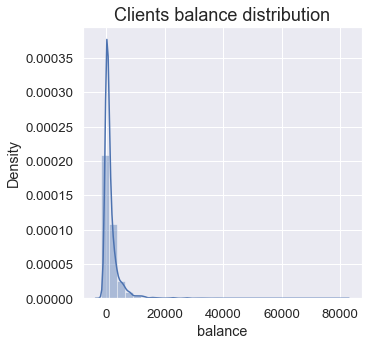

In [22]:
distribution_plot(bank,'balance','Clients balance distribution')

In [23]:
bank['balance'].describe()

count     4264.000000
mean      1615.070356
std       3149.297499
min      -1884.000000
25%        182.000000
50%        625.000000
75%       1840.750000
max      81204.000000
Name: balance, dtype: float64

We can see that the clients' yearly balance distribution is right-skewed with the mean yearly balance of 1615 euros and
with the maximum value of 81204 euros and the minimum of -1884 euros (note that the balance can be negative).

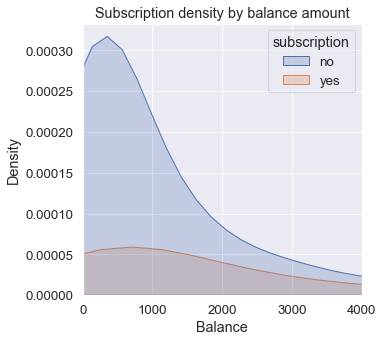

In [24]:
f, ax = plt.subplots(figsize=(5,5))
ax.set_title('Subscription density by balance amount')
ax.set_xlim(0,4000)
    
sns.kdeplot(data=bank,x='balance',hue='subscription',shade=True,ax=ax).set_xlabel('Balance')
plt.show()

It is evident that the probability of subscription to deposit is higher for customers with higher yearly balances (the ratio of 
subscribers over non-subscribers increases with the amount of the balance) which is what is expected as customers with higher
balance have extra money they do not actively use which can be placed into a deposit.

### How the fact of having a housing loan affects the marketing campaign outcome?

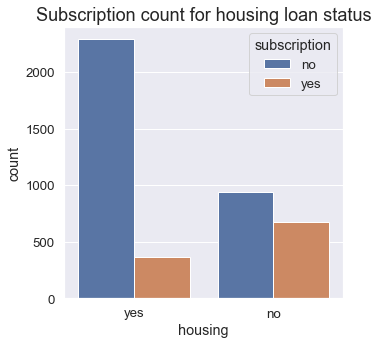

In [25]:
countplot_compare(bank,'housing','subscription','Subscription count for housing loan status',(5,5))

As it can be seen, the majority of contacted clients had a housing loan.

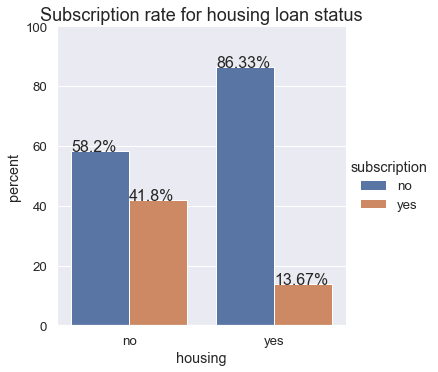

In [26]:
plot_cat_perc(bank,'housing','subscription','Subscription rate for housing loan status',5,5/5)

It is evident that the subscription probability for clients who did not have a housing loan was significantly higher than 
the subscription probability among clients with such loan. This makes a lot of sence sicnce people with a housing loan 
are more likely to have no extra money for a deposit as they need to repay their loan.

### How the fact of having a personal loan affects the marketing campaign outcome?

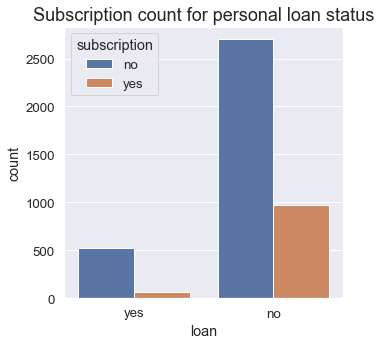

In [27]:
countplot_compare(bank,'loan','subscription','Subscription count for personal loan status',(5,5))

Interestingly, among the clients contacted during the campaign the number of people who did not have any personal loan was
higher than the number of clients with such a loan (quite the opposite was observed for housing loans).

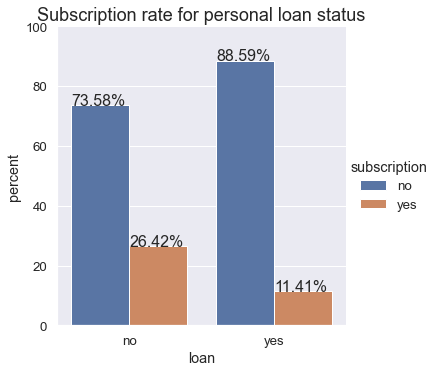

In [28]:
plot_cat_perc(bank,'loan','subscription','Subscription rate for personal loan status',5,5/5)

Again, as in the case of the housing loan, the probability of subscription to a deposit is higher for customers without any
personal loans.

### How the marketing campaign outcome was affected by the means costumers were contacted?

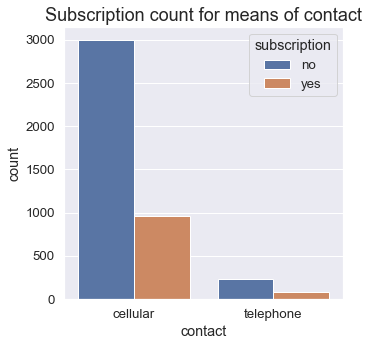

In [29]:
countplot_compare(bank,'contact','subscription','Subscription count for means of contact',(5,5))

We can see that the majority of the customers were contacted via cellular phone and only a small amount of people were contacted
by telephone.

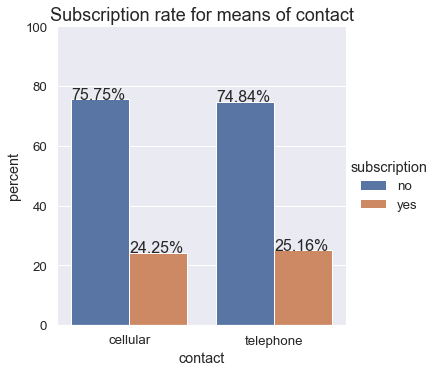

In [30]:
plot_cat_perc(bank,'contact','subscription','Subscription rate for means of contact',5,5/5)

We can see that the probability of subscription was roughly the same when people were contacted by either cellular phone or telephone.
Thus, this variable did not affect the outcome of the campaign that much. 

### Does the day of the month matter for the outcome of the marketing campaign?

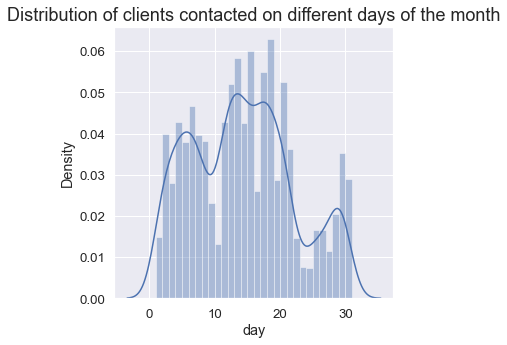

In [31]:
distribution_plot(bank,'day','Distribution of clients contacted on different days of the month')

Interestingly, on some days the amount of contated customers was unusually low. This is the case of days 11, 23, 24 and 28,
however we will not hypothesize about the reasons of this phenomenon as it is out of scope of this project.

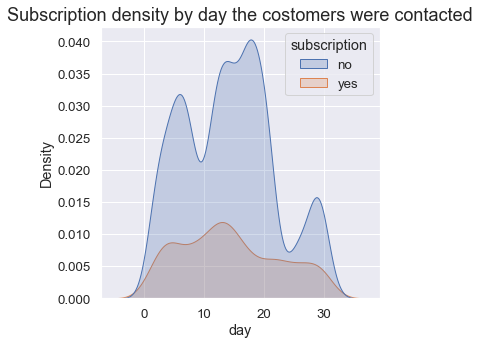

In [32]:
subsription_dist_by_feature(bank,'day','Subscription density by day the costomers were contacted')

We can see that the difference between the percentages of non-subscribers and subscribers 
(and thus the probability of subscription) changes over different days of the month. 

Interestingly, on the days with the lowest
number of contacted clients (days 23 and 24) the probability of subscription was very high (the difference beetween
                                                                                            the percentages of non-subscribers
                                                                                                    and subscribers was very low).
We can speculate that this high subscription probability is due to the fact that the days 23-24 of the month usually correspond to
the pay day, which can affect a client's willingness to subscribe to a deposit.


### Does it matter during which month we will carry out the campaign?

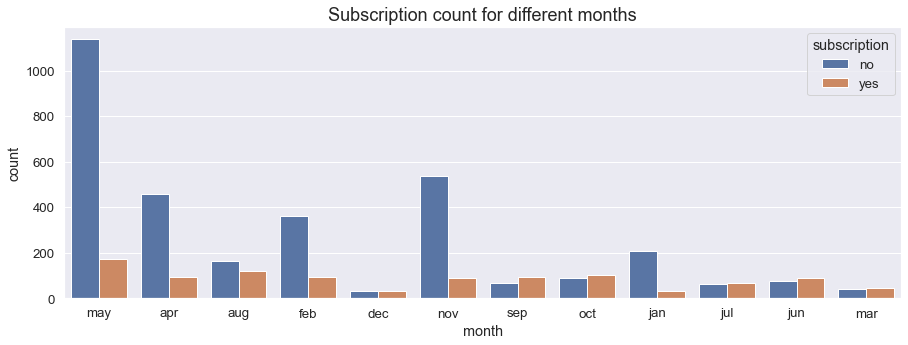

In [33]:
countplot_compare(bank,'month','subscription','Subscription count for different months',(15,5))

As it can be seen, the majority of the clients in the campaign were contacted in May and the smallest amount of customers was contacted in March.

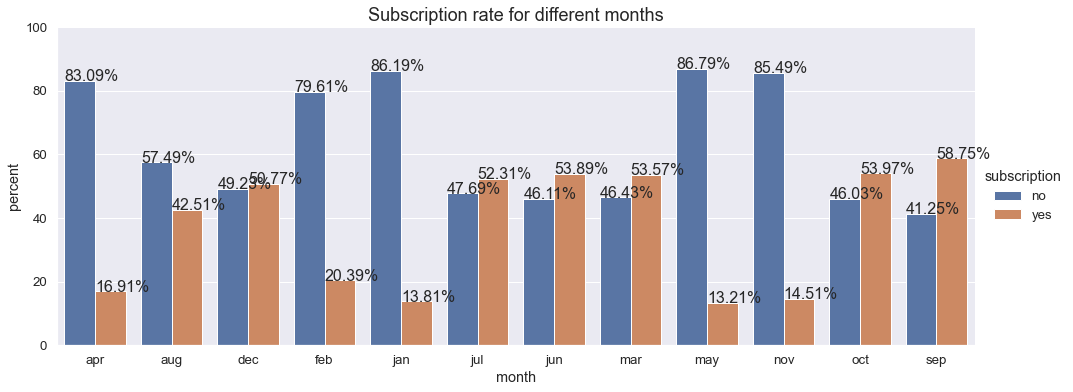

In [34]:
plot_cat_perc(bank,'month','subscription','Subscription rate for different months',5.27,13.7/5.27)

It is easy to see that the month of the year when customers were contacted had significant effect on the outcome of the campaign.

Strikingly, the probability of subscribtion was higher than 50% for the clients contacted in September, October, March, June, July and December,
whereas for customers conacted in May, November, January and April the probability of subscription was lower than 20%.

### Does the marketing campaign outcome is related to the last contact duration?

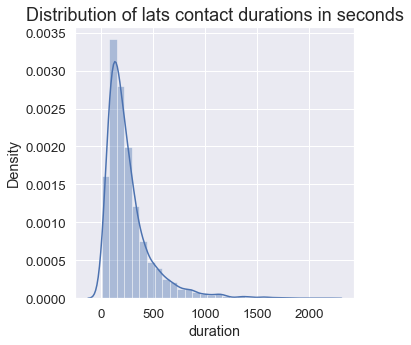

In [35]:
distribution_plot(bank,'duration','Distribution of lats contact durations in seconds')

We can see that most of the last clients' contacts lasted between 70 and 220 seconds, and some contacts lasted up to 2000 seconds.

Let's analyze how the contact durations were related to the subscription probability.

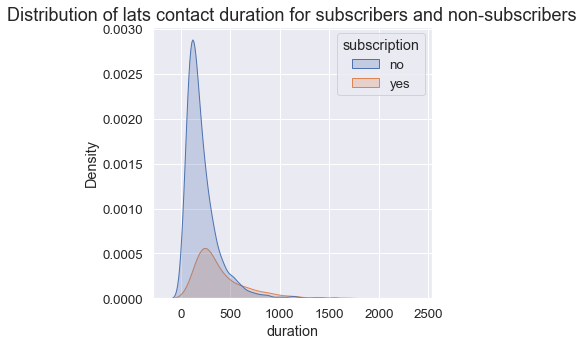

In [36]:
subsription_dist_by_feature(bank,'duration','Distribution of lats contact duration for subscribers and non-subscribers')

We can clearly see that for longer call durations the subscription probability was higher. Also, for the contacts that
lasted more than 650 seconds the probability of client's subscription to the deposit was higher than the probability of a subscription
refusal.

### Does number of contacts performed in this campaign matter for the outcome of the campaign?

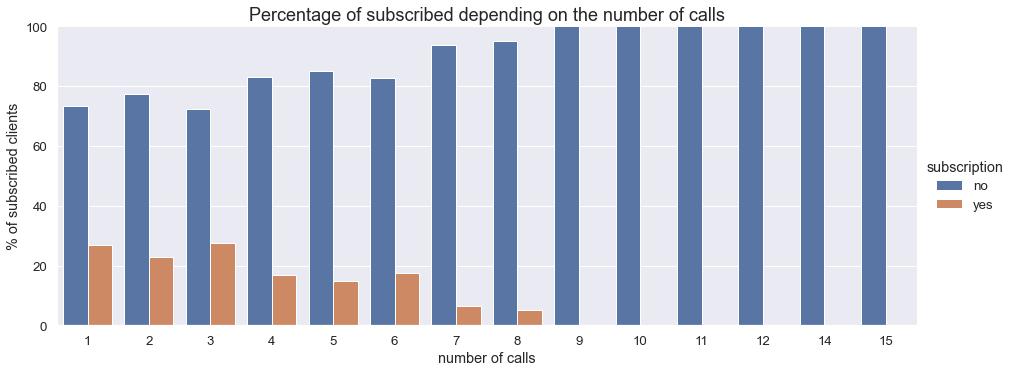

In [37]:
df = bank.groupby('campaign')['subscription'].value_counts(normalize=True)
df = df.mul(100)
df = df.rename('percent').reset_index()
    
g = sns.catplot(x='campaign',y='percent',hue='subscription',data=df,kind='bar',height=5, aspect=13/5)
    
g.ax.set_ylim(0,100)
g.ax.set_title('Percentage of subscribed depending on the number of calls',fontsize=18)
g.ax.set_xlabel('number of calls')
g.ax.set_ylabel('% of subscribed clients')

plt.show()

We can see that,as an overall trend, the number of contacts performed in the campaign matters for the campaign's outcome. 

Although, the percentage of subscribers was really similar for the clients who were contacted from one to three
times in this campaign. Interestingly, for the group of clients who were contacted trice in this campaign
the percentage of subscribers was the highest.

When the number of contacts exceeded three, the percentage of subscribers generally decreased with the number of calls 
performed during the current campaign.

### Does the number of days that passed by after the client was last contacted from a previous campaign matter?

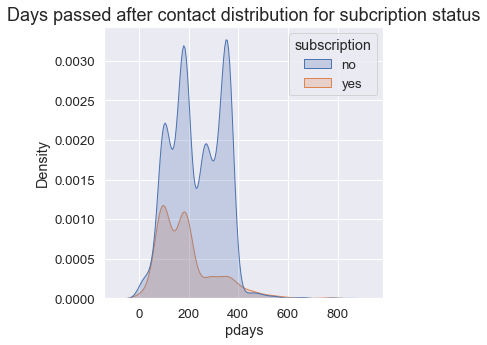

In [38]:
subsription_dist_by_feature(bank,'pdays','Days passed after contact distribution for subcription status')

We can see that the number of days that passed by after the client was last contacted from a previous campaign really
mattered for the current campaign's outcome.

The probability of subscription dropped drastically for the group of clients who were contacted more than 230 days before  
from a previous campaign.

However, for the clients who were contacted more than 410 days before from a previos campaign,
the subscription probability was even higher than 50%, although we can see from the plot that the total amount of these customers was very low and
they generally did not matter for the campaign's outcome.

### Does number of contacts performed before this campaign matters for the campaign outcome?

Now, we will analyze how the number of contacts for the same client performed before this campaign affected
the results of the current campaign.

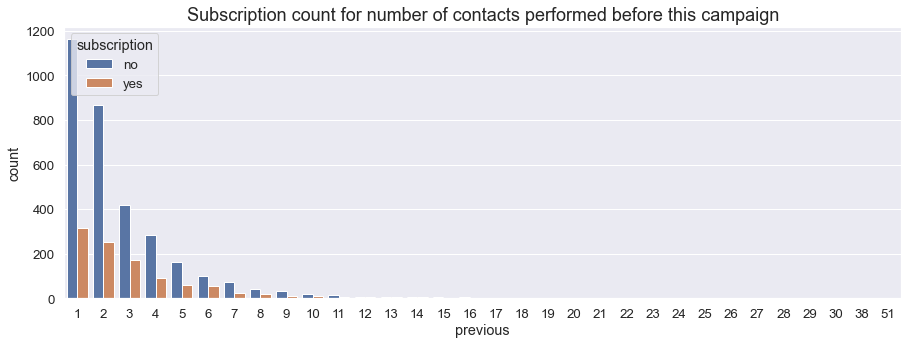

In [39]:
countplot_compare(bank,'previous','subscription','Subscription count for number of contacts performed before this campaign',(15,5))

We can see that most of the clients were contacted only once before the campaign. Also, a significant amout of customers
were contacted two, three or four times before the current campaign.

Very few customers were contacted more than 11 times, so we will further analyze the subscription probability for the
clients who were contacted less than 12 times before the current campaign.

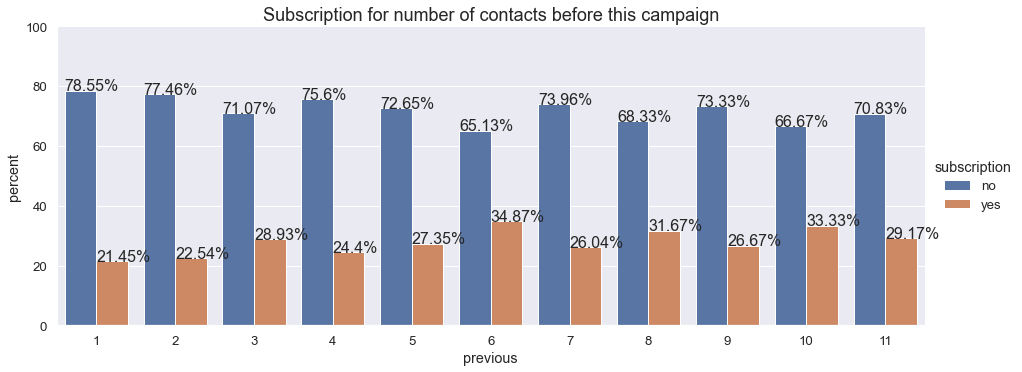

In [40]:
plot_cat_perc(bank[bank.previous<12],'previous','subscription','Subscription for number of contacts before this campaign',5,13/5)

We can see that overall the number of previous contacts affected clients' desicions on whether subscribe or not to deposit.

For clients who were contacted only once or twice before this campaign, the subscription probability was the lowest: 21.45% and 22.54%
respectively. 

Interestingly, for the customers who were contacted six, eight or ten times, the subscription probability was the highest:
        34.87%,31.67% and 33.33% correspondingly.
        
However, overall there is no clear relation between the number of contacts performed before and the outcome of the current campaign.

### Did outcome of the previous marketing campaign affect subscription?

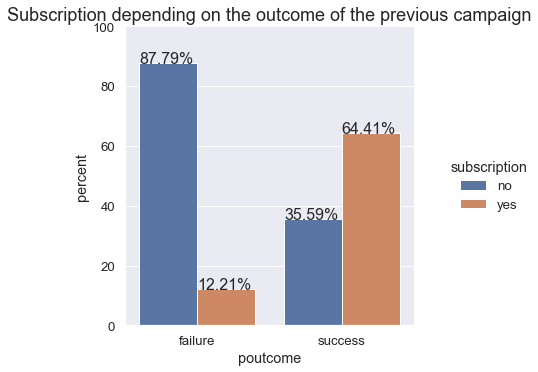

In [41]:
plot_cat_perc(bank,'poutcome','subscription','Subscription depending on the outcome of the previous campaign',5,5/5)

We can see that the outcome of the previous campaign definetely affected the current campaign: the subscription probability
among the clients who subscribed during the previous campaign was around 64.4%, whereas among the clients who did not subscibe
the previous time, only around 12.2% subscribed during the current campaign. 

## Machine Learning 

Let's now process the data and build machine learning models to predict the outcome of the bank deposit marketing campaign.

### Target column

In [42]:
bank['target']=np.where(bank['subscription']=='yes',1,0)
bank['target'].value_counts(dropna=False)

0    3227
1    1037
Name: target, dtype: int64

There were 1037 positive and 3227 negative outcomes in this campaign.

### Split training and test data sets

In [43]:
# Split data between train and test data sets
from sklearn.model_selection import train_test_split

random_seed = 5
#bank_train, bank_test = train_test_split(bank, test_size=0.3, 
                                                          # random_state=random_seed, stratify=bank['target'])

data_train, data_test, target_train, target_test = train_test_split(bank[['age', 'job', 'marital', 
                                                                          'education', 'default', 'balance', 'housing',
                                                                          'loan', 'contact', 'day', 'month', 'duration',
                                                                          'campaign', 'pdays','previous', 'poutcome']],
                                                                    bank['target'],stratify=bank['target'],
                                                                    random_state=random_seed )
print(data_train.shape)
print(data_test.shape)
print()
print(target_train.value_counts(normalize=True))
print()
print(target_test.value_counts(normalize=True))

(3198, 16)
(1066, 16)

0    0.756723
1    0.243277
Name: target, dtype: float64

0    0.757036
1    0.242964
Name: target, dtype: float64


### Variable transformation

We will divide the feature variables into three groups: categorical variables, categorical ordinal variables and numerical variables.
Then, we will define a preprocessor with **ColumnTransformer** wich will process each of these groups of variables correspondingly.

**ColumTransformer** splits the original dataset into three subsets corresponding to the three groups of the variables that we defined.

Then, it transforms each group with the corresponding transformer (**OneHotEncoder** for categorical varriables, **OrdinalEncoder**
                                                                  for categorical ordinal variables and **Standard Scaler**
                                                                  for numerical variables). 

Finally, the transformer concatenates the three transformed subsets into one dataset.


In [44]:
# Create lists of different types of features
categorical_col=['job','marital','default','housing','loan','contact','month','poutcome']
categorical_ordinal=['previous','education']
numerical_col=['age','balance','day','duration','campaign','pdays']

In [45]:
# Define variable prepocessors
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()
categorical_ordinal_preprocessor=OrdinalEncoder()

In [46]:
# Variable preprocessing altogether
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_col),
   ('standard_scaler', numerical_preprocessor, numerical_col),
   ('ordinal-encoder',categorical_ordinal_preprocessor,categorical_ordinal)])

Now, as we preprocessed the data and split it into train and test subsets, we can build the first machine learning model to
make our predictions.

### Logistic regression

First let's build a Logistic Regression model.
We will include hyperparameter optimization into this model: we will search for the best value of the hyperparameter C which 
    represents the inverse of regularization strength. 

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

#Define our Logistic Regression model
parameters = {'C':[0.1, 1, 10]}
model_lr = make_pipeline(preprocessor, GridSearchCV(LogisticRegression(),parameters))

In [48]:
# Display pipline diagram
from sklearn import set_config
set_config(display='diagram')
model_lr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'pdays']),
                                                 ('ordinal-encoder',
                                                  OrdinalEncoder(),
                                                  ['previous', 'education'])])),
                ('gridsearchcv',
                 GridSearchCV(estimator=LogisticRegression(),
                              param_grid={'C': [0.1, 1, 10]}))])

As you can see, the pipeline of the model includes data transformation with OneHotEncoder,StandardScaler and OrdinalEncoder, and it
includes Logistic Regression estimator with grid search for the best value of the hyperparameter C.

Let's now fit the model to the train data.

In [49]:
# Fit the model to the train data
_ = model_lr.fit(data_train, target_train)

For the sake of an example, we can compare how well the model predicted the first 20 values in the test target data.

In [50]:
# Predict first 15 values in the test subset
print('Model predictions for the first 15 values',model_lr.predict(data_test)[:15])

# First 15 values of the test target data
print('Actual values:',np.array(target_test[:15]))

Model predictions for the first 15 values [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
Actual values: [0 0 1 0 0 0 0 1 0 0 0 0 1 0 0]


We can see that the model predicted 3 false negative values and 1 false positive

Let's calculate the accuracy of the model on the test data set.

In [51]:
# Model test accuracy
model_lr.score(data_test, target_test)

0.8311444652908068

We can see that the accuracy of our Logistic Regression model on the test data is around 0.831 which is good enough.

Let's visualize a confusion matrix so we can have a better idea about the prediction capacity of the model.

Confusion Matrix


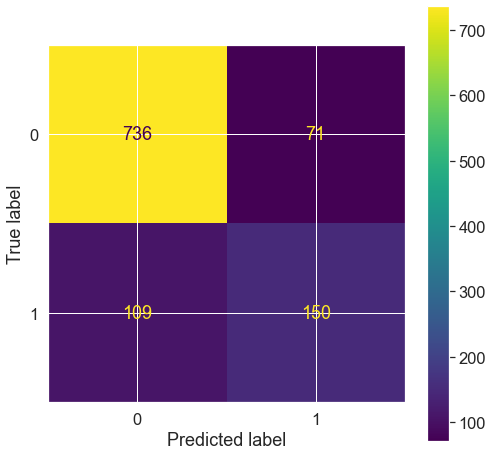

In [52]:
# Plot confusion matrix
from sklearn.metrics import plot_confusion_matrix
sns.set(rc={"figure.figsize":(8, 8)},font_scale=1.5)

print('Confusion Matrix')
plot_confusion_matrix(model_lr, data_test, target_test)

As we can see, from the total of 1066 values, the model correctly predicted 150 positives and 736 negative values, however it 
predicted 109 false positives and 71 false negatives.

### Support Vector Classifier

Now, we will see if we can improve the accuracy of our predictions if we apply another machine learning algorithm.

We can build a model based on support vectors (SVM). Although this machine learning algorithm is more computationally demanding
than Logistic Regression, the size of our data set permits us to use SVM to make our predictions.

We will also include hyperparameter optimization in this model: we will search for the best value for the hyperparameter C, which 
    represents the inverse of regularization strength
    as well as the best value of the parameter gamma, which can be seen as
     the inverse of the radius of influence of samples selected by the model as support vectors.

In [53]:
# Define the model
from sklearn.svm import SVC

parameters = {'C':[0.1, 1, 10],'gamma':[0.001,0.01,'scale',0.1]}
model_svm = make_pipeline(preprocessor, GridSearchCV(SVC(),parameters))

In [54]:
# Show the diagram of the pipeline
set_config(display='diagram')
model_svm

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'pdays']),
                                                 ('ordinal-encoder',
                                                  OrdinalEncoder(),
                                                  ['previous', 'education'])])),
                ('gridsearchcv',
                 GridSearchCV(estimator=SVC(),
                              param_grid={'C': [0.1, 1, 10],
                                          'gamma': [0.001, 0.01, 'scale',
                                                    0.1]}))])

As you can see, the pipeline of the model includes data transformation with OneHotEncoder,StandardScaler and OrdinalEncoder, and it also
includes Support Vector Classifier estimator with grid search for the best values of the hyperparameter C and the parameter gamma.

Let's now fit the model to the train data.

In [55]:
# Fit the svm model to the train data
_ = model_svm.fit(data_train, target_train)

And now let's check how well the SVM model predicted the first 15 values of the test target data.

In [56]:
# Predict first 15 values of the test data
print('Model predictions for the first 15 values', model_svm.predict(data_test)[:15])
      
# First 15 values of the test target data
print('Actual values:',np.array(target_test[:15]))

Model predictions for the first 15 values [0 0 0 0 1 0 0 0 0 0 0 0 1 1 0]
Actual values: [0 0 1 0 0 0 0 1 0 0 0 0 1 0 0]


As you can see, this model predicted 2 false negative and 2 false positives in the first 15 values of the test target data set.

Let's now calculate the accuracy of the model on the test data.

In [57]:
# Calculate the accuracy of the model on the test data
model_svm.score(data_test, target_test)

0.8348968105065666

You can see, that we improved the model's accuracy on the test data to 0.835 (remember that the accuracy of the Logistic Regression model
was 0.831).

Let's now take a look at the confusion matrix so we can better uderstand how well the SVM model made predictions on our test data.


Confusion Matrix


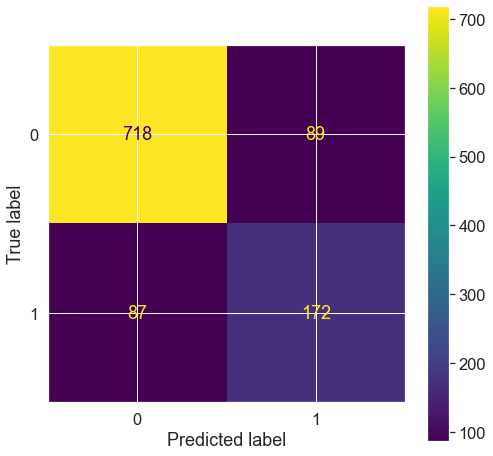

In [58]:
# Plot Confusion matrix
print('Confusion Matrix')
plot_confusion_matrix(model_svm, data_test, target_test)

You can see that we improved the amount of correctly identified true positives (the model predicted 172 true positives ) 
as compared to the prediction of the Logistic Regression model (wich predicted only 150 true positives on the same test data set).

However, the amount of true negatives decreased for the SVM model: this model correctly predicted 718 true negatives,whereas
    the Logistic Regression model correctly predicted 736 negatives on the same test data set.
    
Obviously, for the deposit promotion campaign it is more important that our model can correctly predict the positive outcomes of
the campaign so we can target the most promising clients, hence we can conclude that the **SVM** model is better than the **Logistic 
Regression** for the problem studied in this project.